# Gain Matching

In [16]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import json
import pickle
from pathlib import Path

import awkward as ak
import iminuit
import iminuit.cost
import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from scipy import stats

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)

data_path = Path("data")

In {numref}`content:micromegas`, it was noted that the MicroMeGaS anode is subdivided into a set of distinct zones that can be held at different potentials in order to spatially vary the gain. In this experiment, both the strip-chain (side) regions and final block of pads in the central region were held at a high gain in order to better resolve light particle tracks with low stopping powers (see {numref}`micromegas-anode-gain-region`). 

:::{figure} image/placeholder/placeholder.png
:name: micromegas-anode-gain-region
:width: 400px
:align: center

TODO: add an image of micromegas-anode-gain-region
:::


Following position reconstruction, these gains must be accounted for if the collected charge is to be used for particle identification. Given that the strips, chains, and final central pads were held at the same potential, the relative gain of these regions can be determined solely by looking at the relative gain of the final central pad region. This was experimentally measured by observing the change in charge collected by the rows of pads either side of the high-low gain boundary (see {numref}`micromegas-anode-relative-gain`).

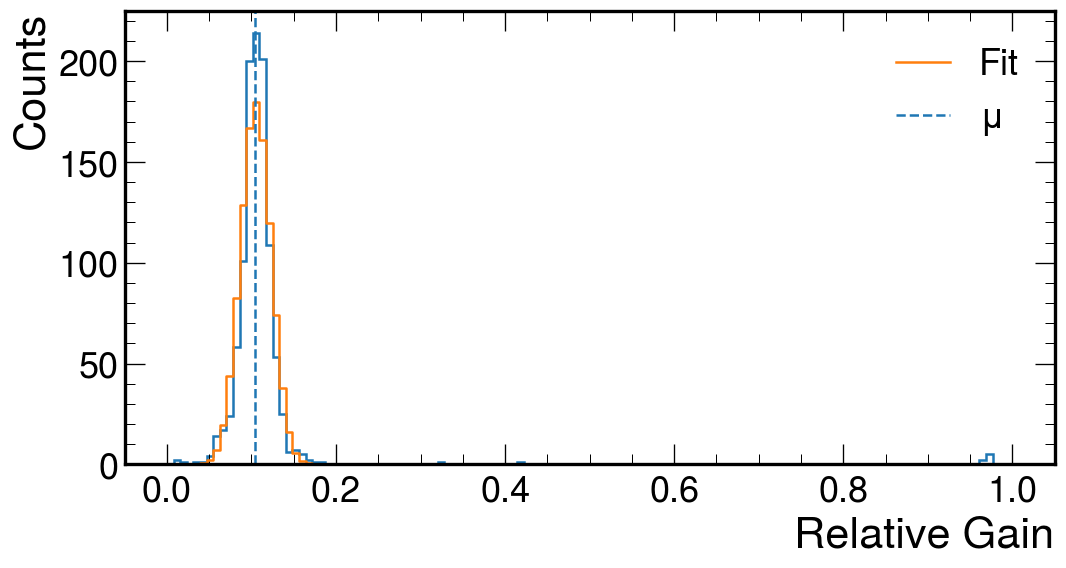

In [21]:
with open(data_path / "gain-hists.pickle", "rb") as f:
    gain_hists = pickle.load(f)


def pdf(x, q, mu, sigma):
    return q * stats.norm(mu, sigma).pdf(x)


def cdf(x, q, mu, sigma):
    return q * stats.norm(mu, sigma).cdf(x)


xe_last = gain_hists["last-rel"].axes[0].edges
y_last = gain_hists["last-rel"].values()

nll_last = iminuit.cost.ExtendedBinnedNLL(y_last, xe_last, cdf)

m_last = iminuit.Minuit(nll_last, q=1, sigma=0.02, mu=0.1)
m_last.limits["mu"] = (0, 1)
m_last.limits["sigma"] = (0, 1)
m_last.limits["q"] = (0, 1e6)
m_last.migrad()

P_last = cdf(xe_last, *m_last.values)

gain_hists["last-rel"].plot1d(label="")
plt.plot(xe_last, np.append(np.diff(P_last), np.nan), drawstyle="steps-post", label="Fit")
plt.axvline(m_last.values["mu"], linestyle="dashed", label="$\mu$")
plt.xlabel("Relative Gain")
plt.ylabel("Counts")
plt.legend();
pass  # Required for next cell's eval

After fitting this distribution with a binned likelihood estimator, the relative gain between the low and high gain regions was found to be {eval}`f"{m_last.values['mu']:.3f}"`.